# NYC Yellow Taxi Fare Prediction

## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
import pickle
from urllib.parse import quote
from sklearn.preprocessing import MinMaxScaler

## Import necessary API
import sys
sys.path.append('../../../../')
from api.v2.util.data_load import data_load
from api.v2.util.get_tag_name import show_column
from api.v2.model.ResNet1d import ResidualBlock, ResNet1D
from api.v2.util.compare_graph import compare_graph

## Import libraries for the model
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results 
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Base Parameter Setting
* Set parameters based on the information identified during EDA (Exploratory Data Analysis).

In [2]:
# Set Bitcoin Data Parameter

# Set MachBase Neo URL address
URL = 'http://127.0.0.1:5654'
# Set Tag Table Name
table = 'taxi'
# Select Tag Name -> Can Check Tag Names Using command 'show_column(URL, table)'
tags = ['extra', 'fare_amount', 'improvement_surcharge', 'mta_tax', 'passenger_count', 'payment_type', 'tip_amount', 'tolls_amount', 'trip_distance', 'trip_duration_minutes', 'total_amount']
# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)
# Set Tag Name
name = quote(tags_, safe=":/")
# Set resample Option -> D(day), H(hour), T(minute), S(second)
resample_freq = None
# Set Start time
start_time = '2015-01-01 00:00:00'
# Set End time 
end_time = '2015-02-01 00:00:00'
# Set TimeFormat - > 'default' or quote('2006-01-02 15:04:05.000000')(Divided down to the nanosecond)
timeformat = 'default'

In [3]:
# Show all Tag Names
# show_column(URL, table)

## NYC yellow Taxi Data Load

In [4]:
# NYC Yellow Taxi Data Load
df = data_load(URL, table, name, start_time, end_time, timeformat, resample_freq)

In [5]:
df

NAME,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,tip_amount,tolls_amount,total_amount,trip_distance,trip_duration_minutes
TIME,,,,,,,,,,,
2015-01-01 00:00:00,0.5,13.5,0.0,0.5,5.0,2.0,0.00,0.0,14.50,4.00,11.433333
2015-01-01 00:00:01,0.5,5.0,0.0,0.5,1.0,2.0,0.00,0.0,6.30,0.80,3.800000
2015-01-01 00:00:03,0.5,9.0,0.3,0.5,1.0,1.0,1.90,0.0,12.20,1.58,10.783333
2015-01-01 00:00:04,0.5,10.5,0.0,0.5,3.0,2.0,0.00,0.0,11.80,2.50,10.666667
2015-01-01 00:00:05,0.5,8.5,0.3,0.5,2.0,1.0,2.00,0.0,11.80,1.30,10.783333
...,...,...,...,...,...,...,...,...,...,...,...
2015-01-31 23:59:55,0.5,12.5,0.3,0.5,1.0,1.0,2.76,0.0,16.56,2.39,17.750000
2015-01-31 23:59:56,0.5,6.5,0.3,0.5,1.0,1.0,1.56,0.0,9.36,0.99,7.016667
2015-01-31 23:59:57,0.5,10.5,0.3,0.5,3.0,2.0,0.00,0.0,11.80,1.75,14.050000


In [6]:
# Split the data into train, valid, test sets
train = df[df.index < '2015-01-20']
valid = df[(df.index < '2015-01-25') & (df.index > '2015-01-20')]
test = df[df.index > '2015-01-25']

## Data Preprocessing
* 1 Min-Max Scaling

### 1. Applying Min-Max Scaling
* Apply to both input data and target data separately to facilitate conversion back to original values after testing. 

In [7]:
# Set up Scalers
scaler_feature = MinMaxScaler()
scaler_target = MinMaxScaler()

# Apply Each Scalers
train_feature = scaler_feature.fit_transform(train.drop(['total_amount'], axis=1).values)
valid_feature = scaler_feature.transform(valid.drop(['total_amount'], axis=1).values)
test_feature = scaler_feature.transform(test.drop(['total_amount'], axis=1).values)

train_target = scaler_target.fit_transform(train['total_amount'].values.reshape(-1, 1))
valid_target = scaler_target.transform(valid['total_amount'].values.reshape(-1, 1))
test_target = scaler_target.transform(test['total_amount'].values.reshape(-1, 1))

# Set Each DataFrames
train_scaled = pd.DataFrame(train_feature, columns=train.drop(['total_amount'], axis=1).columns)  
valid_scaled = pd.DataFrame(valid_feature, columns=valid.drop(['total_amount'], axis=1).columns)
test_scaled = pd.DataFrame(test_feature, columns=test.drop(['total_amount'], axis=1).columns)

# Set Target
train_scaled['total_amount'] = train_target
valid_scaled['total_amount'] = valid_target 
test_scaled['total_amount'] = test_target 

# Save Scaler
with open('./result/taxi_scaler_feature.pkl', 'wb') as file:
    pickle.dump(scaler_feature, file)
    
with open('./result/taxi_scaler_target.pkl', 'wb') as file:
    pickle.dump(scaler_target, file)    

## Dataset & Loader Setup

In [8]:
class Taxi_Dataset(Dataset):

    def __init__(self, df):
        self.freq_data = df.iloc[:,:-1]
        self.label = df.iloc[:,-1:].values

    def __len__(self):
        return len(self.freq_data)

    def __getitem__(self, index):

        input_time_data = self.freq_data.iloc[index,:]
        input_time_data = torch.Tensor(input_time_data).expand(1, input_time_data.shape[0])
        label = self.label[index]

        return input_time_data, label

In [9]:
# Set up datasets  
train_ = Taxi_Dataset(train_scaled)
valid_ = Taxi_Dataset(valid_scaled)
test_ = Taxi_Dataset(test_scaled)

# Set up data loaders
train_dataloader = DataLoader(train_, batch_size=256, shuffle=True)
valid_dataloader = DataLoader(valid_, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_, batch_size=256, shuffle=False)

In [10]:
# Verify DataLoader application and check the shape of the input data
print(list(train_dataloader)[0][0].shape)

torch.Size([256, 1, 10])


## Model Configuration
* Using ResNet1d model.

In [11]:
# Model configuration parameters

# Set ResidualBlock
block = ResidualBlock
# Set the number of ResidualBlocks to use per layer
layers = [2,2,2,2]
# Set the number of classification categories
num_classes = 1

# Learning rate
lr = 0.001

# Model configuration
model = ResNet1D(block, layers, num_classes).to(device)

# Configure loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Check the model architecture
print(model)

ResNet1D(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), paddi

## Model Training

* Save the model with the Best Loss based on the validation data during training.

In [12]:
# Initialize total step
total_step_train = len(train_dataloader)
total_step_valid = len(valid_dataloader)
# Set number of epochs
epoch_in = trange(10, desc='training')
# Initialize best Loss value
best_Loss= np.inf

# Start model training
for epoch in epoch_in:

    model.train()
    running_loss = 0.0
    
    # Initialize loss
    train_loss = []
    
    for batch_idx, (data, target) in enumerate(train_dataloader):
        
        data = data.to(device).float()
        target = target.to(device).float()
        
        optimizer.zero_grad()
        
        # Input to the model
        outputs = model(data)

        # Calculate loss
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss.append(running_loss/total_step_train)
    print(f'\ntrain loss: {np.mean(train_loss)}')
    
    # Initialize loss
    valid_loss = []
    running_loss = 0.0
    
    # Perform validation at the end of each epoch and save the model with the best performance
    with torch.no_grad():
        model.eval()
        
        for batch_idx, (data, target) in enumerate(valid_dataloader):
            
            data_v = data.to(device).float()
            target_v = target.to(device).float()
            
            # Input to the model
            outputs_v = model(data_v) 
            
            # Calculate loss
            loss = criterion(outputs_v, target_v)
            
            running_loss += loss.item()
        
        valid_loss.append(running_loss/total_step_valid)    

    # Save the best model
    if best_Loss > np.mean(valid_loss):
        best_Loss = np.mean(valid_loss)
        torch.save(model, f'./result/NYC_Yellow_Taxi_Full.pt')
        print('Model saved')
    epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")

training:   0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



train loss: 0.005973737061341488
Model saved

train loss: 0.0001852520019336397
Model saved

train loss: 0.00010297723904760186
Model saved

train loss: 6.342989638063442e-05
Model saved

train loss: 5.592836651696336e-05

train loss: 4.8303196924549145e-05

train loss: 4.067027052551953e-05

train loss: 4.221105462763933e-05

train loss: 2.9818383957452632e-05

train loss: 2.5360478648603254e-05
Model saved


## Model Testing

In [13]:
# Load the best model
model_ = torch.load(f'./result/NYC_Yellow_Taxi_Full.pt')

In [14]:
# Initial settings 
output_test = []
target_test = []

with torch.no_grad():
    model_.eval()
    
    for batch_idx, (data, target) in enumerate(test_dataloader):
        
        data_t = data.to(device).float()
        target_t = target.to(device).float()

        outputs_t = model_(data_t)
        
        output_test.append(outputs_t)
        target_test.append(target_t)
        
# Combine tensors into one
combined_tensor_target = torch.cat(target_test, dim=0).cpu()
combined_tensor_pred = torch.cat(output_test, dim=0).cpu()

# Inverse transform using MinMaxScaler 
real_values = scaler_target.inverse_transform(combined_tensor_target.numpy().reshape(-1, 1))
real_pred_values = scaler_target.inverse_transform(combined_tensor_pred.numpy().reshape(-1, 1))        

## Model Performance Evaluation

In [15]:
# Calculate MSE
mse = mean_squared_error(real_values, real_pred_values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(real_values, real_pred_values)
print("R² Score:", r2)

Mean Squared Error: 1.0972544
R² Score: 0.9919719911762798


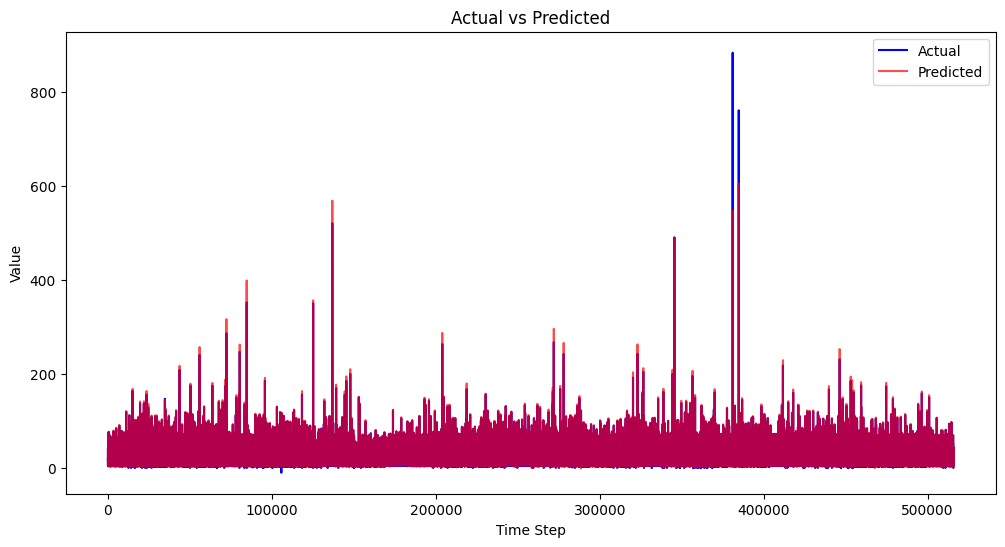

In [16]:
# Compare the test results: Actual values vs Predicted values

# Plot width
x_size=12
# Plot height
y_size=6
# Print Compare_graph
compare_graph(real_values, real_pred_values, x_size, y_size)